In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS Available")
else:
    device = torch.device("cpu")
    print("Using CPU")

MPS Available


In [3]:
train_transforms = transforms.Compose([
                        transforms.RandomAffine(degrees=7, translate=(0.08, 0.08)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomErasing(p=0.05, scale=(0.02, 0.05), ratio=(0.3, 3.3))  # tiny, optional
                        ])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [5]:
# Data loaders
batch_size = 128
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


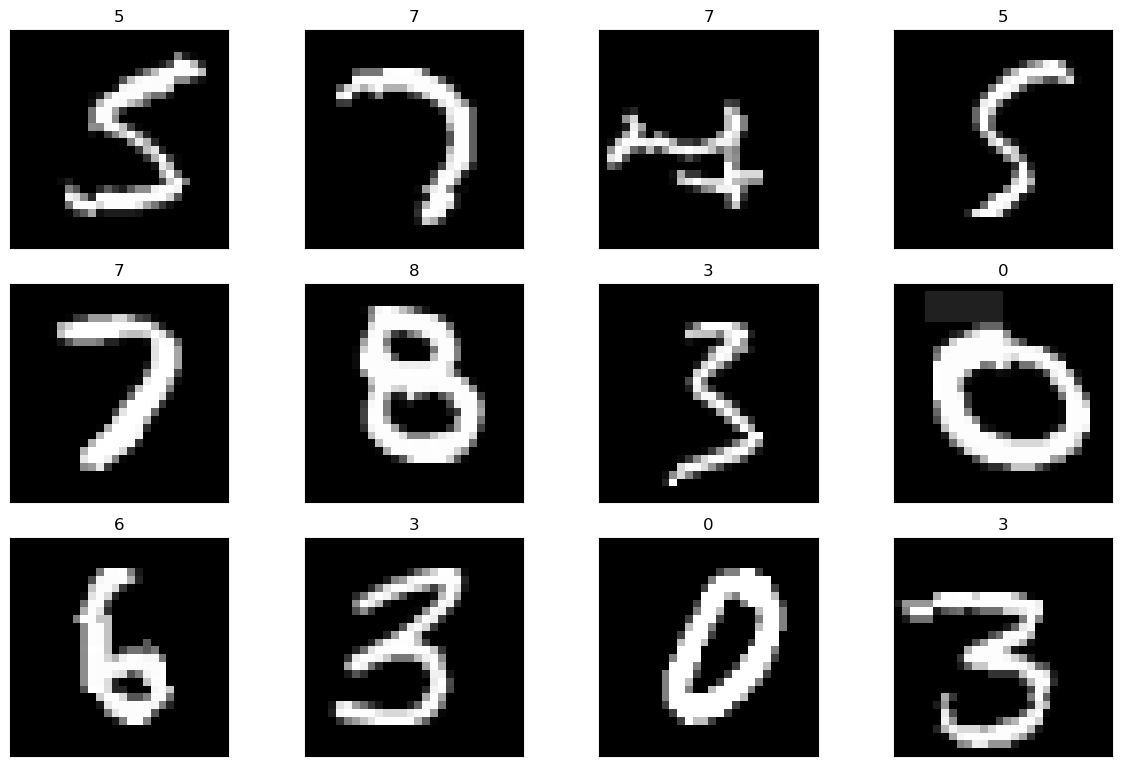

In [6]:
# Visualize some training samples
def visualize_batch():
    batch_data, batch_label = next(iter(train_loader))
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()

visualize_batch()

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Drastically reduced channels to meet <25K constraint
        self.conv1 = nn.Conv2d(1, 14, kernel_size=3, bias=True)  # (3*3*1 + 1) * 14 = 140.   receptive = 3
        self.bn1 = nn.BatchNorm2d(14)  # 28

        self.conv2 = nn.Conv2d(14, 14, kernel_size=3, bias=True)  # (3*3*14 + 1) * 14 = 1778 receptive = 5
        self.bn2 = nn.BatchNorm2d(14)  # 28

        self.conv3 = nn.Conv2d(14, 16, kernel_size=3,  bias=True)  # (3*3*14 + 1) * 16 = 2032 receptive = 7
        self.bn3 = nn.BatchNorm2d(16)  # 32

        self.pool1 = nn.MaxPool2d(2, 2) #  receptive = 8

        self.conv4 = nn.Conv2d(16, 18, kernel_size=3, bias=True)  # (3*3*16 + 1) * 18 =  2610  receptive = 12
        self.bn4 = nn.BatchNorm2d(18)  # 36
        self.conv5 = nn.Conv2d(18, 20, kernel_size=3, bias=True)  # (3*3*18 + 1) * 20 = 3260   receptive = 16
        self.bn5 = nn.BatchNorm2d(20) # 40
        self.pool2 = nn.MaxPool2d(2, 2)  # 14->7 receptive = 18

        self.conv6 = nn.Conv2d(20, 22, kernel_size=3, padding=1, bias=True)  # (3*3*20 + 1) * 22 = 3982 receptive = 26
        self.bn6 = nn.BatchNorm2d(22) # 44
        self.conv7 = nn.Conv2d(22, 22, kernel_size=3, bias=True)  # (3*3*22 + 1) * 22 = 4378 receptive = 34
        self.bn7 = nn.BatchNorm2d(22) # 44


        self.gap  = nn.AdaptiveAvgPool2d(1)   # add this
        self.fc   = nn.Linear(22, 10)         #  22*10 + 10 =220

        # 140 + 28 + 1778 + 28 + 2032 + 32 + 2610 + 36 + 3260 + 40 + 3982 + 44 + 4378 + 44 + 220 = 18,662


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)

        x = F.relu(self.bn6(self.conv6(x)))  # 5x5 -> 3x3
        x = F.relu(self.bn7(self.conv7(x)))  # 5x5 -> 3x3

        x = self.gap(x)                             # (N, 26, 1, 1)
        x = torch.flatten(x, 1)                     # (N, 26) — SAFE (never drops batch)
        x = self.fc(x)                              # (N, 10)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [18]:
# Training and testing functions
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model = Net().to(device)  # Using improved model
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [19]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, epoch, scheduler=None):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        pred = model(data)
        loss = criterion(pred, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Epoch {epoch} | Loss={loss.item():0.4f} | Acc={100*correct/processed:0.2f}%')

    train_accuracy = 100*correct/processed
    train_acc.append(train_accuracy)
    train_losses.append(train_loss/len(train_loader))

    print(f'\nTraining - Epoch {epoch}:')
    print(f'  Accuracy: {correct}/{processed} ({train_accuracy:.2f}%)')
    print(f'  Avg Loss: {train_loss/len(train_loader):.4f}')

    return train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(data)
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_acc.append(accuracy)
    test_losses.append(test_loss)

    print(f'Test Results:')
    print(f'  Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    print(f'  Avg Loss: {test_loss:.4f}')

    return accuracy

In [20]:
# Training setup
from torch.optim.lr_scheduler import OneCycleLR
total_params = model.count_parameters()
print(f"\nModel Parameters: {total_params:,}")
print(f"Model Architecture:")
print(model)
print("="*50 + "\n")

# Use AdamW for better regularization with small models
optimizer = optim.SGD(model.parameters(), lr=0.006, weight_decay=1e-4)
print(f"Optimizer: SGD (lr=0.006, weight_decay=1e-6)")


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
num_epochs = 20



print(f"Loss: CrossEntropyLoss")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Training Samples: {len(train_data):,}")
print(f"Test Samples: {len(test_data):,}")
print("="*60 + "\n")

# Training loop
print("Starting training...")
best_test_acc = 0

for epoch in range(1, num_epochs+1):
    # Train
    train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)

    # Test
    test_accuracy = test(model, device, test_loader, criterion)
    



Model Parameters: 18,662
Model Architecture:
Net(
  (conv1): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(14, 14, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(14, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 18, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(18, 20, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(20, 22, ke

Epoch 1 | Loss=1.1535 | Acc=64.31%: 100%|██████████| 469/469 [00:06<00:00, 68.52it/s] 



Training - Epoch 1:
  Accuracy: 38587/60000 (64.31%)
  Avg Loss: 1.5547
Test Results:
  Accuracy: 9057/10000 (90.57%)
  Avg Loss: 0.9392


Epoch 2 | Loss=0.6907 | Acc=88.46%: 100%|██████████| 469/469 [00:06<00:00, 72.29it/s]



Training - Epoch 2:
  Accuracy: 53074/60000 (88.46%)
  Avg Loss: 0.8768
Test Results:
  Accuracy: 9618/10000 (96.18%)
  Avg Loss: 0.5404


Epoch 3 | Loss=0.4877 | Acc=93.42%: 100%|██████████| 469/469 [00:06<00:00, 73.20it/s]



Training - Epoch 3:
  Accuracy: 56050/60000 (93.42%)
  Avg Loss: 0.5956
Test Results:
  Accuracy: 9719/10000 (97.19%)
  Avg Loss: 0.4308


Epoch 4 | Loss=0.4318 | Acc=95.20%: 100%|██████████| 469/469 [00:06<00:00, 72.02it/s]



Training - Epoch 4:
  Accuracy: 57123/60000 (95.20%)
  Avg Loss: 0.4904
Test Results:
  Accuracy: 9780/10000 (97.80%)
  Avg Loss: 0.3819


Epoch 5 | Loss=0.4934 | Acc=96.08%: 100%|██████████| 469/469 [00:06<00:00, 74.13it/s]



Training - Epoch 5:
  Accuracy: 57649/60000 (96.08%)
  Avg Loss: 0.4437
Test Results:
  Accuracy: 9826/10000 (98.26%)
  Avg Loss: 0.3654


Epoch 6 | Loss=0.4861 | Acc=96.58%: 100%|██████████| 469/469 [00:06<00:00, 72.98it/s]



Training - Epoch 6:
  Accuracy: 57951/60000 (96.58%)
  Avg Loss: 0.4178
Test Results:
  Accuracy: 9829/10000 (98.29%)
  Avg Loss: 0.3608


Epoch 7 | Loss=0.4332 | Acc=96.97%: 100%|██████████| 469/469 [00:06<00:00, 71.57it/s]



Training - Epoch 7:
  Accuracy: 58180/60000 (96.97%)
  Avg Loss: 0.4028
Test Results:
  Accuracy: 9850/10000 (98.50%)
  Avg Loss: 0.3501


Epoch 8 | Loss=0.3994 | Acc=97.22%: 100%|██████████| 469/469 [00:06<00:00, 71.25it/s]



Training - Epoch 8:
  Accuracy: 58330/60000 (97.22%)
  Avg Loss: 0.3932
Test Results:
  Accuracy: 9832/10000 (98.32%)
  Avg Loss: 0.3568


Epoch 9 | Loss=0.3648 | Acc=97.50%: 100%|██████████| 469/469 [00:06<00:00, 72.25it/s]



Training - Epoch 9:
  Accuracy: 58497/60000 (97.50%)
  Avg Loss: 0.3838
Test Results:
  Accuracy: 9853/10000 (98.53%)
  Avg Loss: 0.3505


Epoch 10 | Loss=0.3440 | Acc=97.68%: 100%|██████████| 469/469 [00:06<00:00, 72.46it/s]



Training - Epoch 10:
  Accuracy: 58606/60000 (97.68%)
  Avg Loss: 0.3769
Test Results:
  Accuracy: 9863/10000 (98.63%)
  Avg Loss: 0.3404


Epoch 11 | Loss=0.3945 | Acc=97.69%: 100%|██████████| 469/469 [00:06<00:00, 72.19it/s]



Training - Epoch 11:
  Accuracy: 58616/60000 (97.69%)
  Avg Loss: 0.3736
Test Results:
  Accuracy: 9878/10000 (98.78%)
  Avg Loss: 0.3371


Epoch 12 | Loss=0.3808 | Acc=97.89%: 100%|██████████| 469/469 [00:06<00:00, 72.57it/s]



Training - Epoch 12:
  Accuracy: 58737/60000 (97.89%)
  Avg Loss: 0.3689
Test Results:
  Accuracy: 9868/10000 (98.68%)
  Avg Loss: 0.3390


Epoch 13 | Loss=0.3880 | Acc=98.07%: 100%|██████████| 469/469 [00:06<00:00, 71.68it/s]



Training - Epoch 13:
  Accuracy: 58842/60000 (98.07%)
  Avg Loss: 0.3646
Test Results:
  Accuracy: 9879/10000 (98.79%)
  Avg Loss: 0.3361


Epoch 14 | Loss=0.3343 | Acc=98.00%: 100%|██████████| 469/469 [00:06<00:00, 71.61it/s]



Training - Epoch 14:
  Accuracy: 58800/60000 (98.00%)
  Avg Loss: 0.3627
Test Results:
  Accuracy: 9893/10000 (98.93%)
  Avg Loss: 0.3313


Epoch 15 | Loss=0.3538 | Acc=98.15%: 100%|██████████| 469/469 [00:06<00:00, 70.68it/s]



Training - Epoch 15:
  Accuracy: 58892/60000 (98.15%)
  Avg Loss: 0.3581
Test Results:
  Accuracy: 9902/10000 (99.02%)
  Avg Loss: 0.3302


Epoch 16 | Loss=0.3777 | Acc=98.21%: 100%|██████████| 469/469 [00:06<00:00, 73.36it/s]



Training - Epoch 16:
  Accuracy: 58926/60000 (98.21%)
  Avg Loss: 0.3579
Test Results:
  Accuracy: 9916/10000 (99.16%)
  Avg Loss: 0.3259


Epoch 17 | Loss=0.3129 | Acc=98.31%: 100%|██████████| 469/469 [00:06<00:00, 75.25it/s]



Training - Epoch 17:
  Accuracy: 58983/60000 (98.31%)
  Avg Loss: 0.3548
Test Results:
  Accuracy: 9912/10000 (99.12%)
  Avg Loss: 0.3258


Epoch 18 | Loss=0.3686 | Acc=98.29%: 100%|██████████| 469/469 [00:06<00:00, 72.51it/s]



Training - Epoch 18:
  Accuracy: 58976/60000 (98.29%)
  Avg Loss: 0.3528
Test Results:
  Accuracy: 9912/10000 (99.12%)
  Avg Loss: 0.3247


Epoch 19 | Loss=0.3306 | Acc=98.38%: 100%|██████████| 469/469 [00:06<00:00, 72.45it/s]



Training - Epoch 19:
  Accuracy: 59030/60000 (98.38%)
  Avg Loss: 0.3510
Test Results:
  Accuracy: 9924/10000 (99.24%)
  Avg Loss: 0.3233


Epoch 20 | Loss=0.3652 | Acc=98.47%: 100%|██████████| 469/469 [00:06<00:00, 71.41it/s]



Training - Epoch 20:
  Accuracy: 59079/60000 (98.47%)
  Avg Loss: 0.3493
Test Results:
  Accuracy: 9910/10000 (99.10%)
  Avg Loss: 0.3242


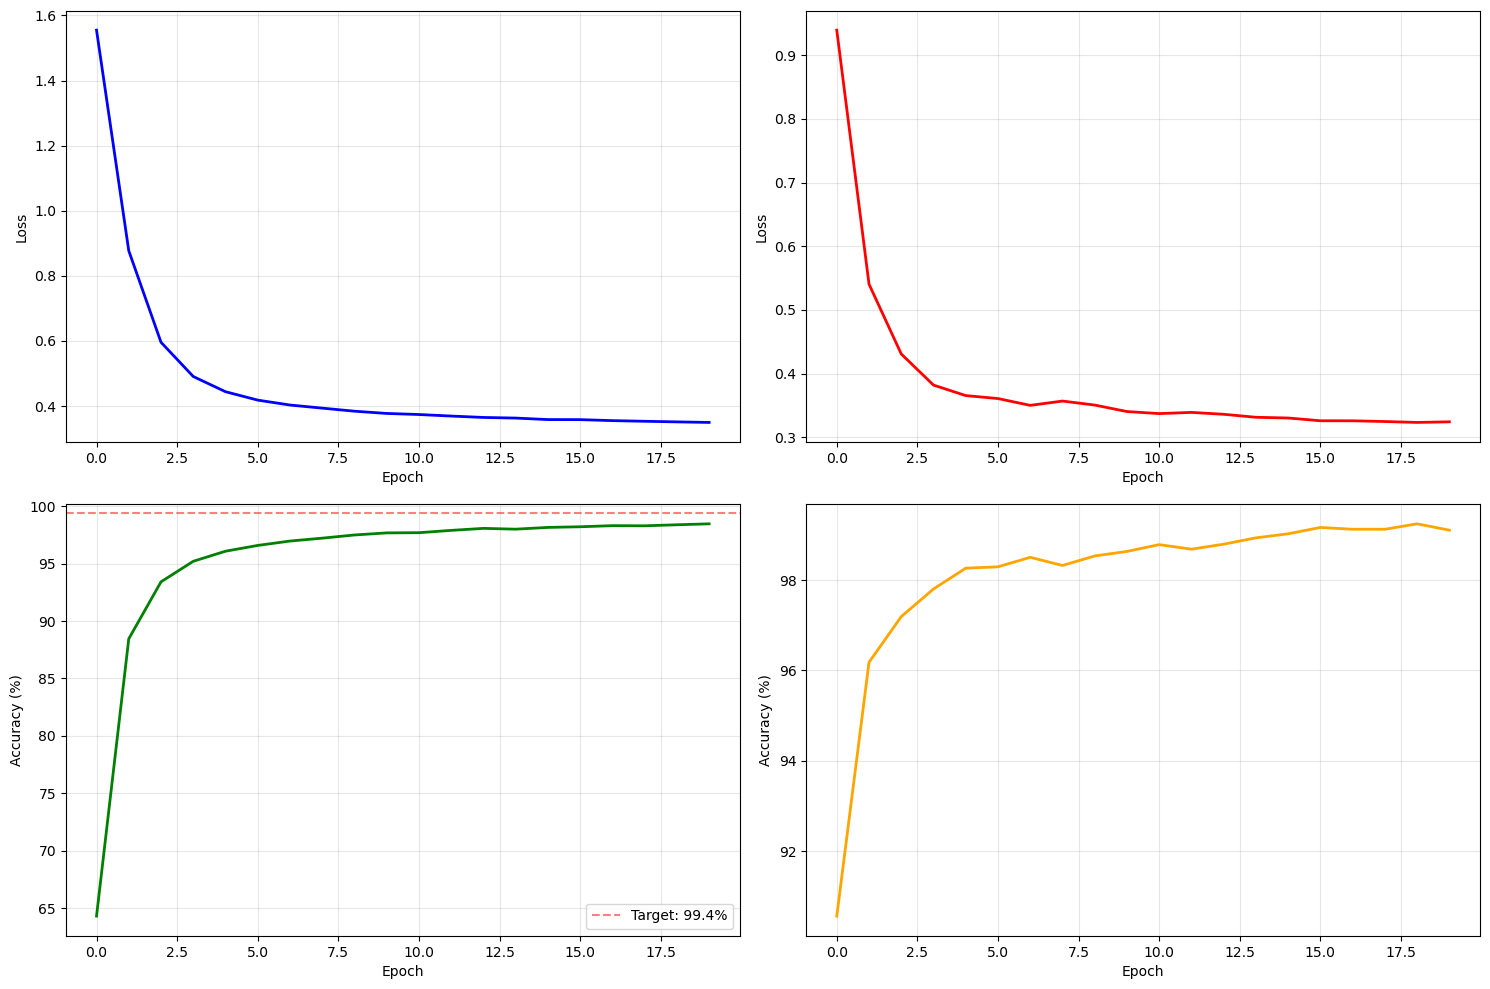


Model Parameters: 18,662 (< 25,000 ✓)
Final Training Accuracy: 98.47%
Final Test Accuracy: 99.10%
Best Test Accuracy: 0.00%
First Epoch Training Accuracy: 64.31%

⚠ First epoch accuracy was 64.31% (target was 99.4%)
  Tips to improve:
  - Try the LightweightNet or UltraLightNet models
  - Increase learning rate slightly
  - Use smaller batch size for more updates


In [21]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
axs[0, 0].plot(train_losses, 'b-', linewidth=2)
#axs[0, 0].set_title(f"Training Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axs[1, 0].plot(train_acc, 'g-', linewidth=2)
#axs[1, 0].set_title(f"Training Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].axhline(y=99.4, color='r', linestyle='--', alpha=0.5, label='Target: 99.4%')
axs[1, 0].legend()

# Test Loss
axs[0, 1].plot(test_losses, 'r-', linewidth=2)
#axs[0, 1].set_title(f"Test Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True, alpha=0.3)

# Test Accuracy
axs[1, 1].plot(test_acc, 'orange', linewidth=2)
#axs[1, 1].set_title(f"Test Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].grid(True, alpha=0.3)

#plt.suptitle(f"Training Results - {model_name} ({total_params:,} parameters)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final summary
print(f"\n{'='*60}")
#print(f"FINAL SUMMARY - {model_name}")
print(f"{'='*60}")
print(f"Model Parameters: {total_params:,} (< 25,000 ✓)")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"First Epoch Training Accuracy: {train_acc[0]:.2f}%")

if train_acc[0] >= 99.4:
    print(f"\n✓ SUCCESS: Achieved {train_acc[0]:.2f}% training accuracy in first epoch!")
else:
    print(f"\n⚠ First epoch accuracy was {train_acc[0]:.2f}% (target was 99.4%)")
    print("  Tips to improve:")
    print("  - Try the LightweightNet or UltraLightNet models")
    print("  - Increase learning rate slightly")
    print("  - Use smaller batch size for more updates")

print(f"{'='*60}")